<table style="width: 100%; border-style: none;">
<tr style="border-style: none">
<td style="border-style: none; width: 1%; text-align: left; font-size: 16px"> Universit&auml;t zu K&ouml;ln</td>
<td style="border-style: none; width: 1%; font-size: 16px">&nbsp;</td>
</tr>
</table>
<hr>
<h1 style="font-weight:bold; text-align: center; margin: 0px; font-size: 30px; padding:0px;">Bachelorarbeit</h1>
<h1 style="font-weight:bold; text-align: center; margin: 0px; font-size: 30px; padding:0px;">Operatorausbreitung in zufälligen Quantenschaltkreisen</h1>
<hr>
<h3 style="font-weight:bold; text-align: center; margin: 0px; font-size: 20px; padding:0px; margin-bottom: 20px;">Wintersemester 2023</h3>
<hr>

**Abgabe**: 20.02.2023

**Name**: <font color="red">Ali Can Yildirim</font>


Dieses Notebook enthält den Code, mit dem die Simulationen für die Operatorausbreitung im zufälligen Quantenschaltkreis durchgeführt wurden. Der Code wurde auf dem PGI8Cluster laufen gelassen um 100 Durchläufe der Operatorausbreitung zu simulieren. Alle generierten Daten sind in einem sepraten Notebook **Random_Circuit_Model_Auswertung_final.ipynb** ausgewertet worden.

Benötigte Pakete:

In [12]:
using ITensors
using LinearAlgebra
using Random
using DelimitedFiles
using Printf

Bevor das zufällige Quantenschaltkreis erstellt werden kann benötigen wir eine Funktion die uns Haar-verteilte Matrizen erzeugt und diese Matrizen direkt zu ITensoren umwandelt. Der Algorithmus um dies zu erreichen wurde in der Bachelorarbeit in Abschnitt 3.3 erklärt.

In [13]:
#=Der Input der Funktion ist ein ITensor.Index 
Die Funktion bekommt min. ein Index, elaubt durch den "..." Operator auch eine beliebige andere Anzahl an Indizes, sodass
Tensoren von Rang 4 und Rang 2 mit einer Funktion erzeugt werden können.
=#
function generate_gate(idx1, idx...; elT = ComplexF64)
    
    #Gesamtanzahl der Indizes bzw. Rang des Haar-verteilten Tensors der generiert werden soll
    N_legs = length(idx) + 1
    #Dimension des ersten Indizes
    hilb = dim(idx1)
    
    #Hilberträume müssen auf allen sites gleich sein(ruft Fehler auf, wenn einer der Indizes nicht mit den anderen überieinstimmt)
    @assert all(i -> dim(i) == hilb, idx)
    
    #Implementierung des Algorithmus zur Generierung Haar-verteilter Matrizen aus Kapitel 3.3:
    
    #Initialisiere quadratische Matrix A der richtigen Größe mit komplexen standardnormalverteilten Einträgen
    A = randn(elT, hilb^N_legs, hilb^N_legs)
    #QR-Zerlegung der Matrix A
    Q,R = qr(A)
    #Die Diagonalmatrix signR bzw. im Haupttext \Lambda ist so konstruiert, dass ihre Einträge der Phase der Matrix 
    #R entsprechen
    signR = diagm(sign.(real(diag(R))))
    #Multipliziere signR mit der unitären Matrix Q um eine Haar-verteilte Matrix zu erhalten
    Q = signR*Q
    
    #Erstelle mit der Haar-veteilten Matrix ein ITensor mit der richtigen Anzahl an physikalischen Indices, 
    #vgl. Abbildung 5.2
    #(ein Tensor von Rang 2 entspricht einer 2x2 Matrix mit 2 physiklaischen Indices, 
    #ein Tensor von Rang 4 entspricht einer 4x4 Matrix mit 4 physiklaischen Indices, etc.)
    
    #Hilfsvariable um Matrix in ein ITensor umzuwandeln
    hilbs = repeat([hilb], N_legs)
    #Wandle die Matrix Q in einen ITensor um mit der entsprechenden Anzahl an Indizes und Zuordnung der Indizes
    return ITensor(reshape(Q, hilbs...,hilbs...), idx1, idx..., prime(idx1), prime.(idx)...)
end

generate_gate (generic function with 1 method)

Als nächstes wird mit Hilfe der Funktion **generate_gate** eine Funktion **Layer** geschrieben, welche für den entsprechenden Zeitpunkt $\tau$ die Lage $V(\tau)$ bestehend aus Haar-verteilter Matrizen $V_{s,s+1}(\tau)$ erzeugt. Die Anzahl $L$ an Gitterpunkte kann gerade oder ungerade sein. Der Fall $L$ gerade ist in der Bachelorarbeit gezeichnet, wo zu geraden Zeitpunkten $\tau$ an den Rändern jeweils ein Tensor von Rang 2 wirkt und bei $\tau$ ungerade ausschließlich Tensoren von Rang 4 wirken, vergleiche Abb. 5.2 der Bachelorarbeit. Bei $L$ ungerade ist die Geometrie hingegen so, dass sowohl bei $\tau$ gerade als auch bei $\tau$ ungerade genau ein Randtensor von Rang 2 wirkt. Bei $\tau$ gerade wirkt der Randtensor von Rang 2 auf Gitterpunkt eins. Hingegen wirkt bei $\tau$ ungerade der Rand Tensor von Rang 2 auf Gitterpunkt $L$. Auf alle anderen Gitterpunkte wirken Tensoren von Rang 4.

In [14]:
#Generiert eine Lage zum Zeitpunkt t (bzw. \tau in der Bachelorarbeit) bestehend aus Haar-verteilten Tensoren entsprechend der 
#Geometrie des zufälligen Quantenschaltkreises. 

#Der Input ist der Zeitpunkt t, die Größe L der Kette und ein Vektor mit ITensor Indizes der Länge L
function Layer(t,L,sites)
    
    #Circuit mit gerader Anzahl an Gitterpunkte (L gerade)
    if L%2 == 0
        #even layer (tau gerade):
        if t%2 == 0
            #Initialisiere Array um die Lage V gefüllt mit Haar-verteilten Tensoren zu speichern
            V = Vector{ITensor}(undef, (L÷2)+1)
            
            #Tensoren von Rang 2 am Rand, d.h. generate_gate bekommt nur ein Index als Input
            V[1] = generate_gate(sites[1])
            V[end] = generate_gate(sites[L])

            #Alle Tensoren von Rang 4 generieren
            for j in 2:L÷2
                #generate_gate bekommt die beiden Indizes  als Input, die zum Zeitpunkt tau interagieren 
                V[j] = generate_gate(sites[2*(j-1)], sites[2*j - 1])
            end

        #odd layer (tau ungerade):
        else
            #Initialisiere Array um die Lage V gefüllt mit Haar-verteilten Tensoren zu speichern
            V = Vector{ITensor}(undef, L÷2)

            #Bei einem Schaltkreis mit L gerade, besteht die Lage für tau ungerade nur aus Tensoren von Rang 4
            for j in 1:L÷2
                V[j] = generate_gate(sites[2*j - 1], sites[2*j])
            end

        end
    #Circuit mit ungerader Anzahl an Gitterpunkte (L ungerade)
    else
        #Initialisiere Array um die Lage V gefüllt mit Haar-verteilten Tensoren zu speichern
        #Für L ungerade bestehen die Lagen für tau gerade bzw. ungerade tau aus gleich vielen Tensoren 
        V = Vector{ITensor}(undef, ((L-1)÷2)+1)
        
        #even layer (tau gerade):
        if t%2 == 0
            #Tensoren von Rang 2 am Rand
            V[1] = generate_gate(sites[1])
            
            for j in 2:(L-1)÷2 + 1
                #Alle anderen Tensoren sind von Rang 4
                V[j] = generate_gate(sites[2*(j-1)], sites[2*j - 1])
            end

        #odd layer (tau ungerade):
        else
            #Tensoren von Rang 2 am Rand
            V[end] = generate_gate(sites[L])
            
            for j in 1:(L-1)÷2
                #Alle anderen Tensoren sind von Rang 4
                V[j] = generate_gate(sites[2*j - 1], sites[2*j])
            end

        end
    end
        

    return V
end

Layer (generic function with 1 method)

Die folgende Funktion **single_timestep** benutzt die Funktion **Layer** um eine Lage Haar-verteilter Tensoren $V(\tau)$ zu erzeugen und diese dann im Heisenbergbild als $V^{\dagger}(\tau)S_{0}V(\tau)$ auf den MPO $S_{0}$ anzuwenden. So wird ein Zeitschritt im zufälligen Quantenschaltkreis erzeugt.

In [15]:
#Die Zeitentwicklung nach einem Zeitschritt im Heisenbergbild

#Die Argumente sind: Ein MPO S0, der Zeitpunkt t und die maximal erlaubte Bond Dimension bond_dim
function single_timestep(S0, t, bond_dim)

    #ITensor Indizes des MPOs S0
    sites = siteinds(S0, plev = 0)

    S = copy(S0)
    L = length(S)
    
    #Generiere Lage Haar-verteilter Tensoren zum Zeitpunkt tau
    V = Layer(t, L, sites)  
    
    #Heisenberg'sche Zeitentwicklung:
    
    #Berechnet V^{\dagger}SV, wobei die Bond Dimension des neuen MPOs mit dieser Funktion trunkiert wird, da sie bei der 
    #Kontraktion wächst.
    S = apply(V, S; maxdim = bond_dim, apply_dag=true) 
    
    #Normalisiert den MPO S auf 1
    normalize!(S)
    
    return S
end

single_timestep (generic function with 1 method)

Mit den oben definierten Funktionen kann die Zeitentwicklung im zufälligen Schaltkreis eines MPOs $S_{0}$ erzeugt werden. Wir benötigen noch eine Funktion um $\rho_{R}(s,\tau)$ bzw. $\rho_{L}(s,\tau)$ zu bestimmen. Der Algorithmus um das zu erreichen wurde in der Bachelorarbeit in Abschnitt 5.3 erklärt.

In [16]:
#Funktion berechnet das totale Gewicht aller Paulistrings mit rechten Endpunkt x_r in der Basisentwicklung von S(\tau):

function rho_R(S,x_r)
    
    sites = siteinds(S, plev = 0)
    Sc = copy(S)
    
    #Bringe den MPO Sc in gemischt-kanonische Form mit Orthogonalisierungszentrum bei x_r, damit die Kontraktion der Tensoren 
    #links von x_r trivial wird, vergleiche Bachelorarbeit:
    orthogonalize!(Sc, x_r)
    L = length(S)
    
    # 1. Berechne den in der Bachelorarbeit genannte Tensor T, indem alle Tensoren rechts von x_r auf die Identität projiziert
    #werden und kontrahiere über alle Bond Indizes in T:
    
    T = ITensor(1)
    for i in L:-1:x_r+1
        #Die i-te Stelle des MPOs Sc wird auf die Identität projiziert
        R = Sc[i]
        #Definiere den Identitäts Tensor an der Stelle i
        id = op("Id", sites[i])
        #projiziere auf die Identität und kontrahiere die Bond Indizes (teile durch sqrt(2) zur Normierung)
        T *= (R * id) * 1/sqrt(2)
    end
    
    # 2. Projiziere Gitterpunkt x_r auf die Pauli Matrizen X, Y und Z:
    
    #Multipliziere die Stelle x_r im MPO Sc mit T
    O = Sc[x_r]
    R = O*T
    
    #Wir projizieren auf die drei Pauli-Matrizen
    projection = ["X", "Y", "Z"]
    #RHO_R ist die Variable in der unser Ergebnis für die Operatordichte rho_R(s,\tau) abgespeichert wird
    RHO_R = 0
    
    #Über alle Pauli-Matrizen iterieren
    for m in projection
       
        #Pauli-Matrizen als Tensor an der Stelle x_r definieren
        proj_op = op(m, sites[x_r])
        #Berechne die Projektion auf einen der drei Pauli-Matrizen (teile durch sqrt(2) zur Normierung)
        rho_xyz = R * proj_op * 1/sqrt(2) 
        #Verknüfe rho_xyz mit sich selber und addiere die Projektionen auf die drei Pauli-Matrizen zusammen(vgl. Bachelorarbeit)
        RHO_R += scalar(rho_xyz * dag(rho_xyz))
        
    end

    
    return abs(RHO_R) 
    
end

#Funktion berechnet das totale Gewicht aller Paulistrings mit linken Endpunkt x_l in der Basisentwicklung von S(\tau):
function rho_L(S,x_l)
    
    sites = siteinds(S, plev = 0)
    Sc = copy(S)
    
    #Bringe den MPO Sc in gemischt-kanonische Form mit Orthogonalisierungszentrum bei x_l, damit die Kontraktion der Tensoren 
    #rechts von x_l trivial wird:
    orthogonalize!(Sc, x_l)
    L = length(S)
    
    # 1. Berechne den Tensor T indem wir die sites 1:x_l-1 auf die Identität projizierne und
    # kontrahiere über alle Bond Indices in T:
    
    T = ITensor(1)
    for i in 1:x_l-1
        #Die i-te Stelle des MPOs Sc wird auf die Identität projiziert
        R = Sc[i]
        #Definiere den Identitäts Tensor an der Stelle i
        id = op("Id", sites[i])
        #projiziere auf die Identität und kontrahiere die Bond Indizes (teile durch sqrt(2) zur Normierung)
        T *= (R * id) * 1/sqrt(2)
    end
    
    # 2. Projiziere site x_l auf die Pauli-Matrizen X, Y und Z
    
    #Multipliziere die Stelle x_l im MPO Sc mit T
    O = Sc[x_l]
    R = O*T
    
    #Wir projizieren auf die drei Pauli-Matrizen
    projection = ["X", "Y", "Z"]
    #RHO_L ist die Variable in der unser Ergebnis für die Operatordichte rho_L(s,\tau) abgespeichert wird
    RHO_L = 0
    for m in projection
       
        #Pauli Matrizen als Tensor an der Stelle x_l definieren
        proj_op = op(m, sites[x_l])
        #Berechne die Projektion auf einen der drei Pauli-Matrizen (teile durch sqrt(2) zur Normierung)
        rho_xyz = R * proj_op * 1/sqrt(2)
        #Verknüfe rho_xyz mit sich selber und addiere die Projektionen auf die drei Pauli-Matrizen zusammen
        RHO_L += scalar(rho_xyz * dag(rho_xyz))
        
    end

    
    return abs(RHO_L) 
    
end

rho_L (generic function with 1 method)

In der Funktion **generate_data** werden alle vorher geschriebenen Funktionen zusammengefasst. Es wird mit **single_timestep** iterativ die Zeitentwicklung eines Operators $S_{0}$ berechnet und nach jedem Zeitschritt die Operatordichten $\rho_{L}(s,\tau)$ und $\rho_{R}(s,\tau)$ $\forall s$ mit den Funktionen **rho_L** bzw. **rho_R** berechnet. Die Funktion erzeugt für ein ausgewählten Seed einen Durchlauf des zufälligen Quantenschaltkreis und gibt die beiden Operatordichten jeweils als Array der Dimension $(\tau+1\times L)$ zurück. Wobei die Operatordichten bei $\tau=0$ auch abgespeichert werden.

In [18]:
#=
Die Funktion bekommt einen Seed zur Reproduzierbarkeit der Daten, 
den Anfangsstring S_0, 
die Gesamtzeit t bis zu der die Simulation laufen soll und 
die maximale Bond Dimension
=#
function generate_data(seed, S_0, t, bond_dim)
    
    #Anfangsstring normieren
    S_prev = copy(S_0) 
    S_prev ./= sqrt(2)

    L = length(S_0)
    #Arrays in denen die Operatordichten für alle Zeiten \tau und Positionen s abgespeichert werden
    RHO_R = zeros(t+1,L)
    RHO_L = zeros(t+1,L)

    #Rechter Endpunkt des Produktoperators (bei \tau = 0) S_prev speichern
    for s in 1:L
        RHO_R[t+1,s] = rho_R(S_prev,s)
        RHO_L[t+1,s] = rho_L(S_prev,s)
    end
    
    #Seed setzen zur Reproduzierbarkeit
    Random.seed!(seed)
    
    #Iteriere über alle Zeiten (wir haben t=16)
    for n in 1:t
        #Der Anfangsstring wird durch die Funktion single_timestep um einen Zeitschritt entwickelt und bekommt den MPO vom 
        #vorherigen Zeitschritt wieder übergeben
        S_new = single_timestep(S_prev, n, bond_dim)
        
        #berechne für den Zeitpunkt t die Operatordichten rho_L(s,\tau) und rho_R(s,\tau) an allen Gitterpunkten
        for s in 1:L

            RHO_R[t+1-n,s] = rho_R(S_new,s)
            RHO_L[t+1-n,s] = rho_L(S_new,s) 
            
        end
        #Setze S_prev auf den neuen Zeitentwickelten MPO S_new um in der nächsten Iteration den nächsten Zeitschritt zu erhalten
        S_prev = S_new
        
    end
    
    
    return RHO_L, RHO_R 
end

generate_data (generic function with 1 method)

Mit dem oben geschriebenen Code kann jetzt die Simulation durchgeführt werden:

In [35]:
#Parameter festlegen:
t = 5 #Gesamte Zeitdauer um die der Anfangsstring S_0 entwickelt werden soll
L = 20 #Länge der Kette
pos0 = (L÷2) + 1 #Position auf die der Anfangsstring S_0 lokalisiert ist
N = 1 #Für den Seed (siehe paar Zeielen weiter unten)
bond_dim = 50 #maximale Bond Dimension

#Name des Ordners wo die Daten abgespeichert werden
output_folder = "results_test"
#erzeugt Ordner mit dem gewählten Namen
mkpath(output_folder)
#Nummern welche als Seed verwendet werden
my_seeds = [s for s in 1:N]

#Hilbertraum des gesamten Systems definieren (die Simulation wurde für q=2 duchgeführt):
sites = siteinds("S=1/2",L)
#Anfangs Paulistring definieren:
Config = repeat(["Id"],L)
Config[pos0] = "Z" #lokalisiert auf pos0 mit Operator Z 
Sz = MPO(sites, Config)
S0 = copy(Sz) 
    
# my_seeds = [999]

#Führe für jeden Seed einen Durchlauf des zufälligen Quantenschaltkreis durch
for seed in my_seeds
    #Zur Zeitmessung
    t1 = time()
    
    #Die Operatordichten für alle Zeiten und Positionen erzeugen
    RHO_L, RHO_R = generate_data(seed, S0, t, bond_dim)

    #Zur besseren Handhabung der Daten
    RHO_L[abs.(RHO_L) .< 1E-16] .= 0
    RHO_R[abs.(RHO_R) .< 1E-16] .= 0

    #Um die Daten den Seeds zuordenen zu können werden sie mit der Seednummer beschriftet
    filename = string(seed) * "_result.txt"
    output_file = joinpath(output_folder, filename) 
    t2 = time()
    #Ausgeben welcher Seed verwendet wurde und wie lange der Durchlauf gedauert hat (nützlich wenn man auf dem Cluster arbeitet)
    @printf("Used Seed: %i, needed time[s]: %0.3f\n", seed, t2 - t1)

    #Fülle die .txt Datei "filename" mit den Operatordichten und speicher sie in "output_folder"
    open(output_file, "w") do io
            writedlm(io, [RHO_L RHO_R])
    end
end
#=
Die Operatordichten werden somit in einer .txt Datei gespeicher die t+1 x 2L Einträge hat. Die ersten L Einträge entsprechen
der Dichte rho_L und die letzten L Einträge der Dichte rho_R
=#

Used Seed: 1, needed time[s]: 2.169


Zum testen des Codes, kann auf einem lokalen Rechner eine Simulation mit der vorigen Zelle durchgeführt werden. Die Daten können mit der folgenden Zelle geladen und geplottet werden. Wobei die Daten, welche auf dem PGI8Cluster erzeugt wurden, wie oben erwähnt, in einem seperaten Notebook **Ising_Modell_Auswertung_final.ipynb** ausgewertet werden.

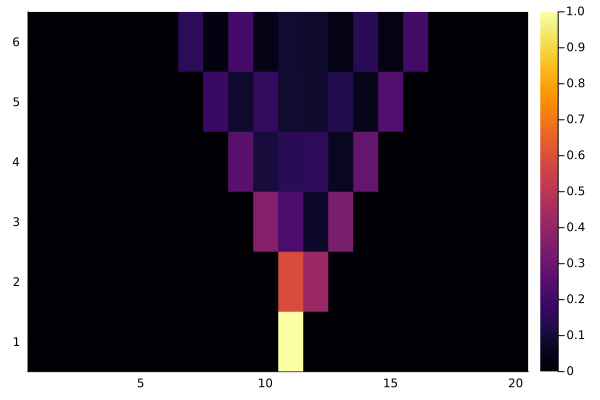

In [36]:
using Plots
#Ordner mit den test Daten (Ordnet enthält die .txt Dateien in denen die Operatordichten gespeichert sind):
output_folder = "results_test"

#Zum uploaden der Daten:
files = joinpath.(output_folder, readdir(output_folder))

L_f = length(files)

#Arrays definieren in die unsere Daten geuploaded werden:
res_r = Vector{Matrix{Float64}}(undef, L_f) #Hier wird rho_l für jeden Seed abgespeichert
res_l = similar(res_r) #Hier wird rho_r für jeden Seed abgespeichert

#Alle Daten im Ordner durchgehen und in res_l und res_r speichern
for (j,f) in enumerate(files[1:L_f])
    res = readdlm(f)
    L2 = size(res,2)
    @assert iseven(L2)
    L = div(L2,2)
    #Die ersten L Werte enstprechen der Operatordichte rho_L
    res_l[j] = reverse(res[:, 1:L],dims=1)
    #Die letzten L Werte enstprechen der Operatordichte rho_R
    res_r[j] = reverse(res[:, L+1:end], dims = 1)
end

#Visualiseren der Daten
heatmap((res_l[1]+res_r[1])/2)